## Chapter 10. Working W/ Data

### Exploring Your Data
After you’ve IDing questions you’re trying to answer + have gotten some data, might be tempted to dive in + immediately start building models + getting answers --> resist this urge. 

**1st step** = explore your data.

### Exploring One-Dimensional Data

Simplest case = a 1D data set == just a collection of numbers (daily avg. # of minutes each user spends on a site, # of times each of a collection of tutorial videos was watched, # of pages of each book in a library, etc.)

An obvious 1st step = compute a few summary stats = see how many DP's we have, the smallest + largest ones, the mean, + the SD. *But even these don’t necessarily give you a great understanding*. 

A good next step = create a histogram to group data into discrete buckets + count how
many DP's fall into each bucket:

In [3]:
import math

def normal_cdf(x,mu=0,sigma=1):
    return (1+math.erf((x-mu)/math.sqrt(2)/sigma))/2

    # plot some cDFs
    x_ax = [x / 10 for  x in range(-50,50)]
    plt.plot(x_ax, [normal_cdf(x,sigma=1) for x in x_ax], linestyle='-'
             ,label="mu=0, sigma=1")
    plt.plot(x_ax, [normal_cdf(x,sigma=2) for x in x_ax], linestyle='--'
             ,label="mu=0, sigma=2")
    plt.plot(x_ax, [normal_cdf(x,sigma=.5) for x in x_ax], linestyle=':'
             ,label="mu=0, sigma=.5")
    plt.plot(x_ax, [normal_cdf(x,mu=-1) for x in x_ax], linestyle='-.'
             ,label="mu=-1, sigma=1")
    plt.legend(loc=4) # bottom-right
    plt.title("Various Normal CDFs")
    plt.show()

def inverse_normal_cdf(p,mu=0,sigma=1,tolerance=.00001):
    """Find the approximate inverse using binary search"""
    
    # if not standard, standardize and re-scale
    if mu != 0 or sigma != 1:
        return mu + sigma*inverse_normal_cdf(p,tolerance=tolerance)
    
    low_z, low_p = -10.0, 0  # normal_cdf(-10) = very close to 0
    hi_z, hi_p = 10.0, 1     # normal_cdf(10) = very close to 1
    
    while hi_z - low_z > tolerance: 
        mid_z = (low_z + hi_z) / 2 # consider midpoint
        mid_p = normal_cdf(mid_z)  # and the CDF's value there
        
        if mid_p < p:
            # if midpoint is still too low, search above it
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # if midpoint is still too high, search below it
            hi_z, hi_p = mid_z, mid_p 
        else:
            break
    
    return mid_z

In [13]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
from collections import Counter
import random

def bucketize(point,bucket_size):
    """Floor a points to the next lower multiple of bucket_size"""
    return bucket_size*math.floor(point/bucket_size)

def make_histogram(points,bucket_size):
    """Buckets the points + counts how many are in each bucket"""
    return Counter(bucketize(point,bucket_size) for point in points)

def plot_histogram(points,bucket_size,title=""):
    histogram = make_histogram(points,bucket_size)
    plt.bar(list(histogram.keys()),list(histogram.values()),width=bucket_size)
    plt.title(title)
    plt.show()

random.seed(0)

# uniform between -100-100
uniform = [200*random.random()-100 for _ in range(10000)]

# normal with mean 0 and SD 57
normal = [57*inverse_normal_cdf(random.random()) for _ in range(10000)]

Both have means close to 0 + SD's close to 58. However, they have very different distributions = v. different max + min, but even knowing that wouldn’t have been sufficient to understand how they differed.

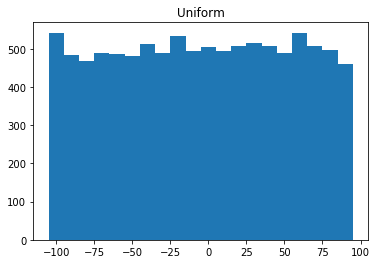

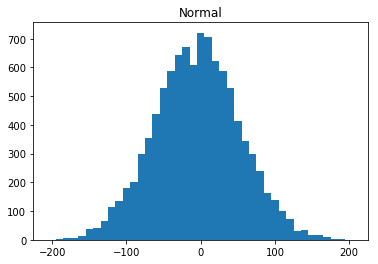

In [16]:
plot_histogram(uniform,10,"Uniform")
plot_histogram(normal,10,"Normal")

### Two Dimensions

Now in addition to daily minutes, we have years of experience. Of course you’d want to understand each dimension individually, but also probably want to scatter the data.
For example, consider another fake data set:

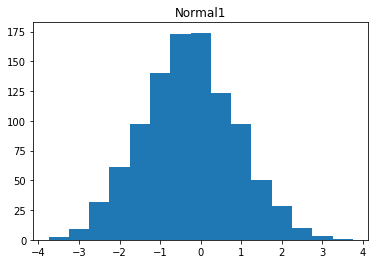

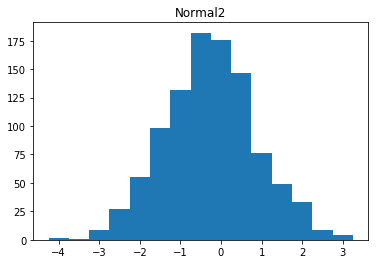

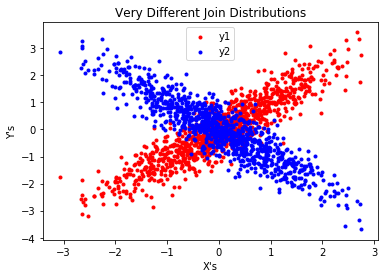

In [23]:
def random_normal():
    """Returns random draw form a Standard Normal Distribution"""
    return inverse_normal_cdf(random.random())

x_ax = [random_normal() for _ in range(1000)]
y_ax1 = [x+random_normal() / 2 for x in x_ax]
y_ax2 = [-x+random_normal() / 2 for x in x_ax]

# both have similar distributions (normal w/ same mean + SD)
plot_histogram(y_ax1,.5,"Normal1")
plot_histogram(y_ax2,.5,"Normal2")

# but different JOINT DISTRIBUTIONS w/ x values
plt.scatter(x_ax, y_ax1, marker='.', color='red', label='y1')
plt.scatter(x_ax, y_ax2, marker='.', color='blue', label='y2')
plt.xlabel("X's")
plt.ylabel("Y's")
plt.legend(loc=9)
plt.title("Very Different Join Distributions")
plt.show()

In [27]:
def dot(v, w):
    """v_1 * w_1 + ... + v_n * w_n"""
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    """v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def mean(x):
    return sum(x) / len(x)

def de_mean(x):
    """translate x by subtracting its mean (so the result has mean 0)"""
    x_bar = mean(x)
    return [x_i - x_bar for x_i in x]

def variance(x):
    """assumes x has at least two elements"""
    n = len(x)
    deviations = de_mean(x)
    return sum_of_squares(deviations) / (n - 1)

def standard_deviation(x):
    return math.sqrt(variance(x))

def covariance(x, y):
    n = len(x)
    return dot(de_mean(x), de_mean(y)) / (n - 1)

def correlation(x, y):
    stdev_x = standard_deviation(x)
    stdev_y = standard_deviation(y)
    if stdev_x > 0 and stdev_y > 0:
        return covariance(x, y) / stdev_x / stdev_y
    else:
        return 0 # if no variation, correlation is zero

# JOINT DISTRIBUTION difference would also be apparent in the correlations
print(correlation(x_ax,y_ax1))
print(correlation(x_ax,y_ax2))

0.9055244658599846
-0.9026656209842727


### Many Dimensions

W/ many dimensions, you’d like to know how ALL the dimensions relate to one another. A simple approach = look @ **correlation matrix**, in which the entry in row i + col j = correlation between the ith dimension and the jth dimension of the data:

In [29]:
def shape(A):
    num_rows = len(A)
    num_cols = len(A[0]) if A else 0
    return num_rows, num_cols

def get_column(A, j):
    return [A_i[j] for A_i in A]

def make_matrix(num_rows, num_cols, entry_fn):
    """returns a num_rows x num_cols matrix
    whose (i,j)-th entry is entry_fn(i, j)"""
    return [[entry_fn(i, j) for j in range(num_cols)]
            for i in range(num_rows)]

def correlation_mtx(data):
    """Returns num_cols*num_cols matrix whose (i,j)th entry
    is the correlation between columns i and j of given data"""
    _, num_columns = shape(data)
    
    def matrix_entry(i,j):
        return correlation(get_column(data,i),get_column(data,j))
    
    return make_matrix(num_columns,num_columns,matrix_entry)

num_points = 100

def random_row():
    row = [None, None, None, None]
    row[0] = random_normal()
    row[1] = -5 * row[0] + random_normal()
    row[2] = row[0] + row[1] + 5 * random_normal()
    row[3] = 6 if row[2] > -2 else 0
    
    return row

random.seed(0)
data = [random_row() for _ in range(num_points)]
correlation_mtx(data)

[[1.0, -0.9811358167114443, -0.6617493801914248, -0.517322308755641],
 [-0.9811358167114445,
  1.0000000000000002,
  0.6818185438510717,
  0.5421152672467888],
 [-0.6617493801914248,
  0.6818185438510717,
  1.0000000000000002,
  0.7461443698023104],
 [-0.517322308755641,
  0.5421152672467889,
  0.7461443698023105,
  0.9999999999999999]]

more visual approach (if you don’t have *too* many dimensions) = make a **scatterplot
matrix** showing all **pairwise scatterplots**. 

To do that, use `plt.subplots()` = allows us to create subplots of our chart given # of
rows + # of columns + returns a **figure object** (not used) + a 2D array of **axes objects** (each of which we’ll plot to):

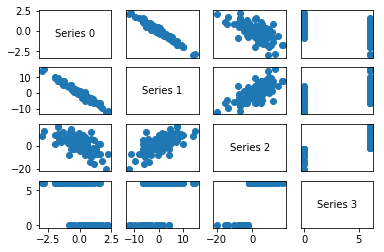

In [30]:
_, num_columns = shape(data)
fix,ax = plt.subplots(num_columns,num_columns)

for i in range(num_columns):
    for j in range(num_columns):
        
        # scatter col_j on x-axis vs. col_i on y-axis
        if i != j:
            ax[i][j].scatter(get_column(data,j),get_column(data,i))
        # unless i ==j, in which case, show series name
        else:
            ax[i][j].annotate("Series " + str(i), (.5,.5),
                              xycoords="axes fraction",
                              ha="center",va="center")
        # then hide axis labels except left + bottom charts
        if i < num_columns - 1:
            ax[i][j].xaxis.set_visible(False)
        if j > 0:
            ax[i][j].yaxis.set_visible(False)            

# Fix bottom right + top left axis labels
#  - wrong b/c charts only have text in them
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())

plt.show()

Looking @ the scatterplots --> series 1 = very negatively correlated w/ series 0, series 2 = positively correlated w/ series 1, + series 3 only takes on values 0 and 6, w/ 0 corresponding to small values of series 2 and 6 corresponding to large values.

This is a quick way to get a rough sense of which of your variables are correlated

In [7]:
def get_domain(email_address):
    """Split on '@' and return the last piece"""
    return email_address.lower().split("@")[-1]

with open("email_address.txt", "r") as f:
    domain_counts - Counter(get_domain(line.strip())
                           for line in f
                           if "@" in line)

FileNotFoundError: [Errno 2] No such file or directory: 'email_address.txt'

### Delimited Files

More often we work w/ files w/ lots of data on each line that're very often either comma or tab-separated. Each line has several fields, w/ a comma/tab indicating where 1 field ends + the next starts.

This gets complicated when you have fields w/ commas + tabs + newlines in them. For this reason, it’s pretty much always a mistake to try to parse them yourself. Instead, use Python’s `csv` module (or `pandas` library).

For technical reasons, always work w/ CSV files in **binary mode** by including a `b` after the `r` or `w` (see Stack Overflow).

If your file has no headers (which means you probably want each row as a list, + which places the burden on you to know what’s in each column), you can use `csv.reader` to iterate over rows, each of which will be an appropriately split list.

Ex: TSV of stock prices:

In [8]:
import csv

def process(date, symbol, price):
    print(date, symbol, price)

with open("tab_delimited_stock_prices.txt", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    
    for row in reader:
        date = row[0]
        symbol = row[1]
        closing_price = float(row[2])
        process(date,symbol,closing_price)

6/20/2014 AAPL 90.91
6/20/2014 MSFT 41.68
6/20/2014 FB 64.5
6/19/2014 AAPL 91.86
6/19/2014 MSFT 41.51
6/19/2014 FB 64.34


If the file has headers, we can skip them (with an inital call to `reader.next()`) or get each row as a `dict` (with headers as keys) by using `csv.DictReader`)

In [9]:
import csv

def process(date, symbol, price):
    print(date, symbol, price)

with open("colon_delimited_stock_prices.txt", "r") as f:
    reader = csv.DictReader(f, delimiter=":")
    
    for row in reader:
        date = row["date"]
        symbol = row["symbol"]
        closing_price = float(row["closing_price"])
        process(date,symbol,closing_price)

6/20/2014 AAPL 90.91
6/20/2014 MSFT 41.68
6/20/2014 FB 64.5


Even if the file doesn’t have headers we can still use `DictReader` by passing it the keys as a `fieldnames` parameter, + we can similarly write out delimited data using `csv.writer`:

In [10]:
todays_prices = {"AAPL":90.91,"MSFT":41.68,"FB":64.5}

with open("comma_delimited_stock_prices.txt", "w") as f:
    writer = csv.writer(f, delimiter=",")
    
    for stock,price in todays_prices.items():
        writer.writerow([stock,price])

`csv.writer` does the right thing if fields themselves have commas in them. Your own hand-rolled writer probably won’t. For example, if you attempt:

In [11]:
results = [["test1", "success", "Monday"],
           ["test2", "success, kind of", "Tuesday"],
           ["test3", "failure, kind of", "Wednesday"],
           ["test4", "failure, utter", "Thursday"]]

# BAD - DON'T DO
with open("bad_csv.txt","wb") as f:
    for row in results:
        f.write(",".join(map(str,tow))) # might have too many commas in it
        f.write("\n") # row might already have newlines

NameError: name 'tow' is not defined

You will end up with a csv file no one will ever be able to make sense of that looks like:

* test1,success,Monday
* test2,success, kind of,Tuesday
* test3,failure, kind of,Wednesday
* test4,failure, utter,Thursday


### Scraping the Web

Fetching web pages = easym, getting meaningful structured info out of them = less so

#### HTML and the Parsing Thereof

Pages on the Web = written in HTML, in which text is (ideally) marked up into **elements** + **their attributes:**

In [12]:
'''<html>
<head>
<title>A web page</title>
</head>
<body>
<p id="author">Joel Grus</p>
<p id="subject">Data Science</p>
</body>
</html>'''

'<html>\n<head>\n<title>A web page</title>\n</head>\n<body>\n<p id="author">Joel Grus</p>\n<p id="subject">Data Science</p>\n</body>\n</html>'

In a perfect world where all web pages are marked up semantically for our benefit, we'd be able to extract data using rules like “find the `<p>` element whose `id` = "subject"
+ return the text it contains.” In the actual world, HTML is not generally well-formed,
let alone annotated. This means we’ll need help making sense of it.

To get data out of HTML, use **BeautifulSoup library** = builds a tree out of  the various elements on a web page + provides a simple interface for accessing them + use the **requests library** = a much nicer way of making HTTP requests than anything built into Python, + use **html5lib** as an HTML parser since Python’s built-in HTML parser = not that lenient = AKA doesn’t always cope well w/ HTML that’s not perfectly formed.

To use Beautiful Soup = pass some HTML into `BeautifulSoup()` function, which will come from the result of a call to `requests.get()`:


In [13]:
from bs4 import BeautifulSoup
import requests

html = requests.get("http://www.google.com").text
soup = BeautifulSoup(html,"html5lib")

After this, we can get pretty far using a few simple methods. We’ll typically work with **Tag objects** = correspond to the tags representing the structure of an HTML page.


In [14]:
# find 1st paragraph + its contents
first_paragraph = soup.find('p')

# second way
first_paragraph2 = soup.p

print(first_paragraph)
print(first_paragraph2)

# get text contents of a Tag via its `text` property
first_paragraph_txt = soup.p.text
# split the text into seperate words
first_paragraph_words = soup.p.text.split()
print("\n",first_paragraph_txt,first_paragraph_words)

# extract tag's attributes via treating it like a `dict`
first_p_id = soup.p['id']      # returns KeyError if no 'id'

<p style="color:#767676;font-size:8pt">© 2018 - <a href="/intl/en/policies/privacy/">Privacy</a> - <a href="/intl/en/policies/terms/">Terms</a></p>
<p style="color:#767676;font-size:8pt">© 2018 - <a href="/intl/en/policies/privacy/">Privacy</a> - <a href="/intl/en/policies/terms/">Terms</a></p>

 © 2018 - Privacy - Terms ['©', '2018', '-', 'Privacy', '-', 'Terms']


KeyError: 'id'

In [15]:
first_p_id2 = soup.p.get('id') # returns None if no 'id'

print("\n",first_p_id2)

# get multiple tags at once
all_paragraphs = soup.find_all('p') # or use soup('p')
paragraphs_with_ids = [p for p in soup('p') if p.get('id')]

print("\n",all_paragraphs,"\n",paragraphs_with_ids)


 None

 [<p style="color:#767676;font-size:8pt">© 2018 - <a href="/intl/en/policies/privacy/">Privacy</a> - <a href="/intl/en/policies/terms/">Terms</a></p>] 
 []


Can find tags with a specific class:

In [16]:
impt_paragraphs = soup('p', {'class': 'important'})
impt_paragraphs2 = soup('p','important')
impt_paragraphs3 = [p for p in soup('p')
                    if 'important' in p.get('class', [])]

Can combine these to implement more elaborate logic

In [17]:
## find every <span> element contained inside a <div> element
#     - warning, will return the same span multiple times
#        if it sits inside multiple divs
#     - be more clever if that's the case
spans_inside_div = [span
                   for div in soup('div')
                   for span in div('span')]

Just this handful of features will allow us to do quite a lot. If you end up needing to do
more-complicated things, check the documentation.

Will need to carefully inspect the source HTML, reason through selection logic, + worry about edge cases to make sure your data is correct. Let’s look at an example: **O’Reilly Books About Data**.

A potential investor in our social network thinks data is just a fad. To prove him wrong, you decide to examine how many data books O’Reilly has published over time. After digging
through its website, you find it has many pages of data books + videos, reachable through 30-items-at-a-time directory pages with URLs like:
http://shop.oreilly.com/category/browse-subjects/data.do?sortby=publicationDate&page=1.

Unless you want to be a jerk + you want your scraper to get banned, before scraping data from a website, 1st check to see if it has some sort of access policy. Looking at:
http://oreilly.com/terms/, there seems to be nothing prohibiting this project. In order to be good citizens, we should also check for a `robots.txt` file, which tells webcrawlers how to behave. The important lines in http://shop.oreilly.com/robots.txt are:

* `Crawl-delay: 30` == should wait 30 seconds between requests
* `Request-rate: 1/30` == should request only one page every 30 seconds

Basically 2 different ways of saying the same thing. (There're other lines that indicate directories not to scrape, but they don’t include our URL, so we’re OK.)

* ***NOTE***: There’s always the possibility that O’Reilly will at some point revamp its website + break all logic in this section.

To figure out how to extract the data, let’s download one of those pages and feed it to
Beautiful Soup:

In [18]:
import requests
from bs4 import BeautifulSoup

url = "https://ssearch.oreilly.com/?q=data"
soup = BeautifulSoup(requests.get(url).text,'html5lib')

If we view the source of the page , we’ll see each book (or video) seems to be uniquely contained in a `<td>` table cell element whose class = `thumbtext`. Therefore, a good first step = find all `td` thumbtext tag elements:

In [19]:
articles = soup('article','result product-result')
print(len(articles))

15


Next we’d like to filter out videos. (The would-be investor is only impressed by
books.) If we inspect the HTML further, we see that each article contains 1+ `a` elements whose `class = "book"`, and whose text looks like `Ebook`: or `Video`: or
`Print`:. It appears the videos contain only one `pricelabel`, whose text starts with
`Video` (after removing leading spaces). This means we can test for videos with:

In [20]:
def is_video(article):
    """Is video if only 1 pricelabel + if stripped text inside 
    pricelabel starts w/ 'Video'"""
    pricelabel = article('a','book')
    return (len(pricelabel)==1 and
           pricelabel[0].text.strip().startswith("Video"))

print(len([article for article in articles if not is_video(article)]))

15


Now we’re ready to start pulling data out of the td elements. It looks like the book title is the text inside an `<a>` tag withing an `<p>` class="title"> tag inside the `<div class="book_text">`:

In [21]:
titles = list(article.find("div","book_text").a.text.strip() for article in articles)
print(titles)

['Interactive Data Visualization for the Web', 'Data Preparation in the Big Data Era', 'Data Driven: Creating a Data Culture', 'Selenium Framework Design in Data-Driven Testing', 'The Big Data Market', 'Oil, Gas, and Data', 'Going Pro in Data Science', 'Data and Social Good', 'Understanding the Chief Data Officer', 'Mapping Big Data', 'The Security Data Lake', 'Not All Data Is Created Equal', '2015 Data Science Salary Survey', 'Managing the Data Lake', 'Python for Data Developers']


The author(s) are in the text of the "note" `<p>`, + are prefaced by a `By` + separated by commas

In [22]:
import re # RegEx
print(list(article.find("div","book_text").find("p","note").text
           for article in articles))

author_names = [article.find("p","note").text
                for article in articles]
(author_names)
# remove leading 'By' and split on commas
#authors = [x.strip() for x in re.sub("^By ", "", author_names).split(",")]

['By Scott Murray', 'By Federico Castanedo', 'By Hilary Mason, DJ Patil', 'By Carl Cocchiaro', 'By Aman Naimat', 'By Daniel Cowles', 'By Jerry Overton', 'By Mike Barlow', 'By Julie Steele', 'By Russell Jurney', 'By Raffael Marty', 'By Mike Barlow, Gregory Fell', 'By John King, Roger Magoulas', "Publisher: O'Reilly Media", "By O'Reilly Media, Inc."]


['By Scott Murray',
 'By Federico Castanedo',
 'By Hilary Mason, DJ Patil',
 'By Carl Cocchiaro',
 'By Aman Naimat',
 'By Daniel Cowles',
 'By Jerry Overton',
 'By Mike Barlow',
 'By Julie Steele',
 'By Russell Jurney',
 'By Raffael Marty',
 'By Mike Barlow, Gregory Fell',
 'By John King, Roger Magoulas',
 "Publisher: O'Reilly Media",
 "By O'Reilly Media, Inc."]

In [67]:
[str(x).strip() for x in [re.sub('By *', '', x) for x in author_names]]#.split(", ")]

['Scott Murray',
 'Federico Castanedo',
 'Hilary Mason, DJ Patil',
 'Carl Cocchiaro',
 'Aman Naimat',
 'Daniel Cowles',
 'Jerry Overton',
 'Mike Barlow',
 'Julie Steele',
 'Russell Jurney',
 'Raffael Marty',
 'Mike Barlow, Gregory Fell',
 'John King, Roger Magoulas',
 "Publisher: O'Reilly Media",
 "O'Reilly Media, Inc."]

ISBN seems to be contained in the link that’s in the thumbheader `<div>`

In [68]:
isbn_link = td.find("div", "thumbheader").a.get("href")
# re.match captures the part of the regex in parentheses
isbn = re.match("/product/(.*)\.do", isbn_link).group(1)

NameError: name 'td' is not defined

And the date is just the contents of the `<span class="directorydate">:`

In [69]:
date = td.find("span", "directorydate").text.strip()

NameError: name 'td' is not defined

Let’s put this all together into a function:

In [71]:
def book_info(td):
    """given a BeautifulSoup <td> Tag representing a book,
    extract the book's details and return a dict"""
    
    title = td.find("div", "thumbheader").a.text
    by_author = td.find('div', 'AuthorName').text
    authors = [x.strip() for x in re.sub("^By ", "", by_author).split(",")]
    isbn_link = td.find("div", "thumbheader").a.get("href")
    isbn = re.match("/product/(.*)\.do", isbn_link).groups()[0]
    date = td.find("span", "directorydate").text.strip()
    
    return {
        "title" : title,
        "authors" : authors,
        "isbn" : isbn,
        "date" : date
    }

In [ ]:
### SCRAPE
from bs4 import BeautifulSoup
import requests
from time import sleep

base_url = "http://shop.oreilly.com/category/browse-subjects/" + \
    "data.do?sortby=publicationDate&page="
books = []
NUM_PAGES = 31 # at the time of writing, probably more by now

for page_num in range(1, NUM_PAGES + 1):
    print("souping page", page_num, ",", len(books)), " found so far"
    url = base_url + str(page_num)
    soup = BeautifulSoup(requests.get(url).text, 'html5lib')

    for td in soup('td', 'thumbtext'):
        if not is_video(td):
            books.append(book_info(td))
    # now be a good citizen and respect the robots.txt!
    sleep(30)

souping page 1 , 0
souping page 2 , 0
souping page 3 , 0
souping page 4 , 0
souping page 5 , 0
souping page 6 , 0
souping page 7 , 0
souping page 8 , 0
souping page 9 , 0


***NOTE***: Extracting data from HTML = more data art than data science.

Now that we’ve collected the data, we can plot the number of books published each year

In [ ]:
def get_year(book):
    """book["date"] looks like 'November 2014' so we need to
    split on the space and then take the second piece"""
    return int(book["date"].split()[1])

# 2014 is the last complete year of data (when I ran this)
year_counts = Counter(get_year(book) for book in books
                      if get_year(book) <= 2014)

import matplotlib.pyplot as plt

years = sorted(year_counts)
book_counts = [year_counts[year] for year in years]
plt.plot(years, book_counts)
plt.ylabel("# of data books")
plt.title("Data")
plt.show()

Unfortunately, the would-be investor looks at the graph and decides that 2013 was “peak
data.

### Using APIs
Many websites + web services provide application programming interfaces (APIs), which allow you to explicitly request data in a structured format == saves you the trouble of having to scrape them

### JSON (and XML)

B/c HTTP = a protocol for transferring text, the data you request through a web API needs to be **serialized** into a string format. Often this serialization uses **JavaScript Object Notation (JSON)**. JavaScript objects look quite similar to Python `dicts`, which makes their string representations easy to interpret:

In [ ]:
{ "title" : "Data Science Book",
"author" : "Joel Grus",
"publicationYear" : 2014,
"topics" : [ "data", "science", "data science"] }

Can parse JSON using `json` module, in particular, `loads()` = deserializes a string representing a JSON object into a Python object:

In [ ]:
import json
serialized = """{ "title" : "Data Science Book",
                "author" : "Joel Grus",
                "publicationYear" : 2014,
                "topics" : [ "data", "science", "data science"] }"""

# parse JSON to create Python dict
